In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.collections import LineCollection
from collections import defaultdict
from matplotlib.patches import Patch
from matplotlib.colors import to_rgba, to_hex
from scipy import stats as sci_stats


In [2]:
fitd = dict()
freqd = dict()
for bfa_name in ['dBFA2', 'hBFA1', 'hBFA2']:
    fitd[bfa_name] = pd.read_csv('Final_data_sets/'+bfa_name+'_all_fitness.csv')
    freqd[bfa_name] = pd.read_csv('Final_data_sets/'+bfa_name+'_all_freqs_tidy.csv')

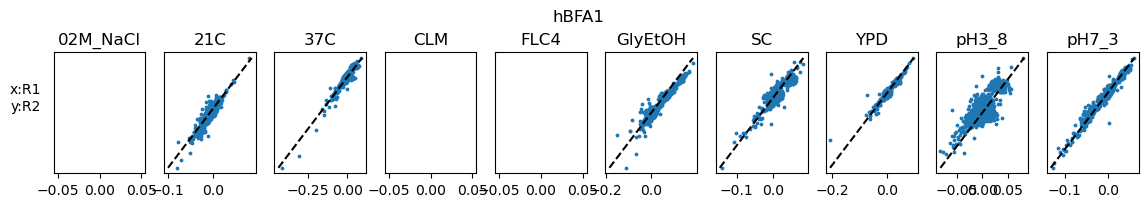

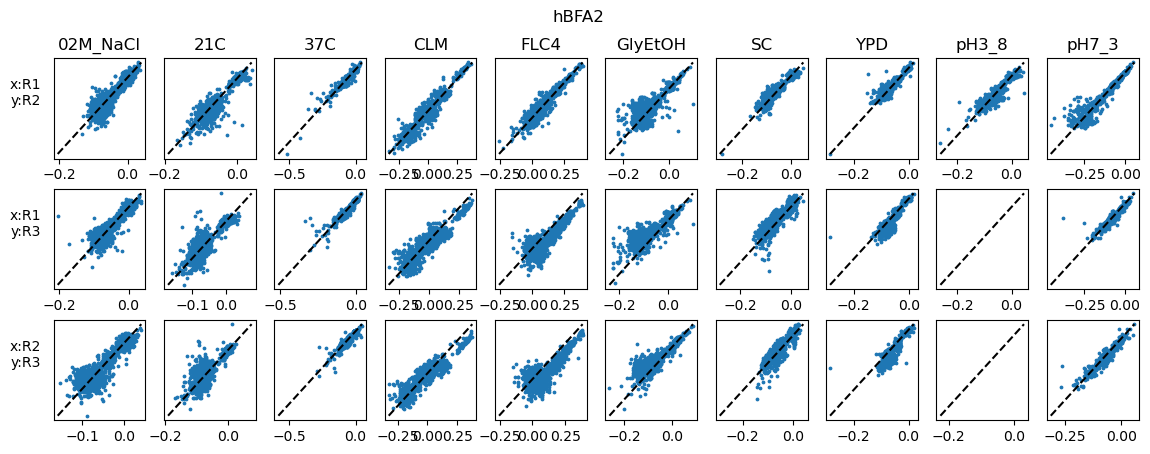

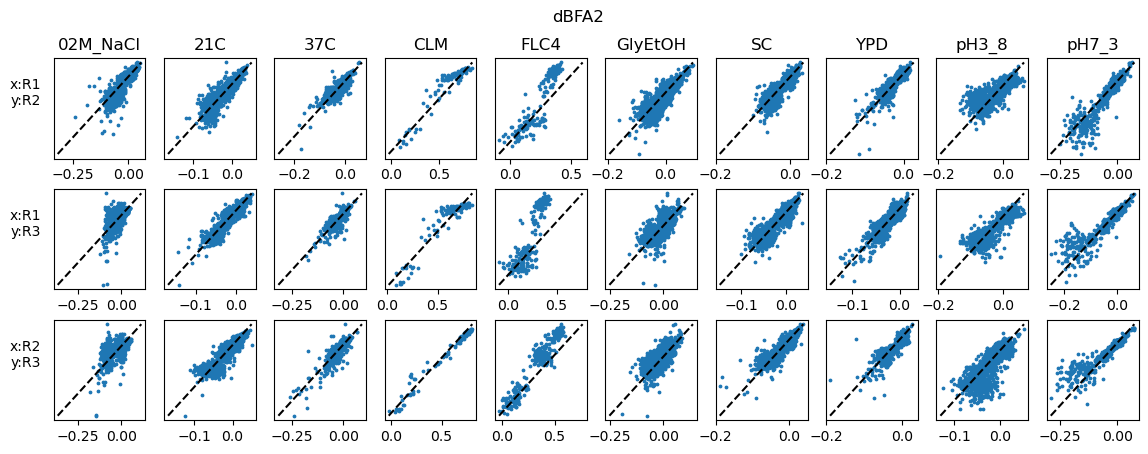

In [8]:
bfas = ['hBFA1', 'hBFA2', 'dBFA2']
bfa_reps = {'hBFA1': ['R1', 'R2'], 'hBFA2': ['R1', 'R2', 'R3'], 'dBFA2': ['R1', 'R2', 'R3']}
for bfa_name in bfas:
    envs = sorted(set(fitd[bfa_name]['Test_Environment']))
    reps = bfa_reps[bfa_name]
    rows = {3:3,2:1}[len(reps)]
    fig, subps = plt.subplots(rows, len(envs), figsize=(14, rows*1.6), dpi=100)
    if len(subps)==len(envs): subps = [subps] # bc of how pyplot does subplots inconsistently
    plt.subplots_adjust(hspace=0.3)
    ec = -1
    for env in envs:
        tmp = fitd[bfa_name][fitd[bfa_name]['Test_Environment']==env]
        ec += 1
        rc = -1
        for rep1 in reps:
            for rep2 in reps[reps.index(rep1)+1:]:
                rc += 1
                if 's_'+rep1 in tmp and 's_'+rep2 in tmp:
                    extent = [min(list(tmp['s_'+rep1]) + list(tmp['s_'+rep2])), max(list(tmp['s_'+rep1]) + list(tmp['s_'+rep2]))]
                    subps[rc][ec].plot(extent, extent, linestyle='dashed', c='k')
                    subps[rc][ec].scatter(tmp['s_'+rep1], tmp['s_'+rep2], s=3)
                    subps[rc][ec].set_yticks([])
                    
                if rc == 0:
                    subps[rc][ec].set_title(env)
                if ec == 0:
                    subps[rc][ec].set_ylabel('x:'+rep1+'\ny:'+rep2, rotation='horizontal', labelpad=20)
    if bfa_name == 'hBFA1':
        fig.suptitle(bfa_name, y=1.15)
    else: 
        fig.suptitle(bfa_name)
                    
                    
    #fig.savefig('../Fitness_data/s_correlations/' + bfa_name + '-' + env + '_unweighted_ave.png')
    #pl.close("all")   

In [15]:
fd = pd.read_csv('Final_data_sets/All_fitness_tidy.csv')
bfa_dats = dict()
good_envs = dict()
all_envs_included = ['YPD', 'SC', '37C', 'pH3_8', 'pH7_3', 'GlyEtOH', 'FLC4', 'CLM', '21C', '02M_NaCl']
icols = ['Barcode', 'Home_Environment', 'Putative_Neutral']
for bfa in ['hBFA1_alpha', 'hBFA2_alpha', 'hBFA2_2N', 'dBFA2_2N']:
    td = fd[(fd['BFA']==bfa.split('_')[0]) & (fd['ploidy']==bfa.split('_')[1])]
    bfa_dats[bfa] = td[['Barcode', 'Test_Environment', 's']].pivot(index='Barcode', columns='Test_Environment', values='s')
    good_envs[bfa] = [i for i in all_envs_included if len([j for j in bfa_dats[bfa][i] if pd.isnull(j)])!=len(bfa_dats[bfa])]
    bfa_dats[bfa] = bfa_dats[bfa].merge(td[icols].drop_duplicates(), on='Barcode', how='left')[icols+good_envs[bfa]]

# Fig 2?
## Outstanding issues:
* Dealing with NaN's - would be great to infer fitness = <-0.25 or something for lineages that go extinct (not by chance)
* For haploids - using data here from 2 BFAs, should be ok to merge but there are some batch effects.


In [16]:
envs_use = ['SC', '37C', 'pH7_3', 'GlyEtOH', 'FLC4', 'CLM']
cpal = sns.color_palette('colorblind')[:1]+sns.color_palette('colorblind')[2:4]+sns.color_palette('colorblind')[6:]
colors = {envs_use[i]: cpal[i] for i in range(len(envs_use))}

def plot_envs(sub, df, envs_use, use_z=False, only_use_envs=[], excluded_home_envs=['Ancestor_YPD_2N'], legend=False, title=None, clip=None, rescale=None):

    if only_use_envs:
        home_envs = only_use_envs
    else:
        home_envs = [i for i in set(df['Home_Environment']) if i not in excluded_home_envs]
        
    td = df[(df['Home_Environment'].isin(home_envs)) & (~df['Putative_Neutral'])].sort_values('Barcode')
    clist = [to_rgba(colors['_'.join(e.split('_')[:-1])]) for e in td['Home_Environment']]
    mat = np.array(td[[e for e in envs_use]])
    #mat = np.nan_to_num(mat, nan=0) # Unclear the best way to handle these cases - I really should have a way to distinguish not measured from low-fitness
    if rescale:
        for e in rescale:
            mat[:, envs_use.index(e)] = mat[:, envs_use.index(e)]*rescale[e]
    lines = np.zeros((len(td), len(envs_use), 2))
    lines[:, :, 0] = np.arange(len(envs_use))
    lines[:, :, 1] = mat
    sub.add_collection(LineCollection(lines, linewidth=0.25, colors=clist, alpha=0.25))

    for env in home_envs:
        sub.plot([], color=colors['_'.join(env.split('_')[:-1])], label='_'.join(env.split('_')[:-1]))

    sub.set_xticks(list(range(len(envs_use))))
    sub.set_xticklabels(envs_use)
    if legend: sub.legend(bbox_to_anchor=(1.5,1), frameon=False)
    if title: sub.set_title(title, y=0.9)
    sns.despine()

/n/home13/mjohnson/anaconda3/envs/milo_py37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


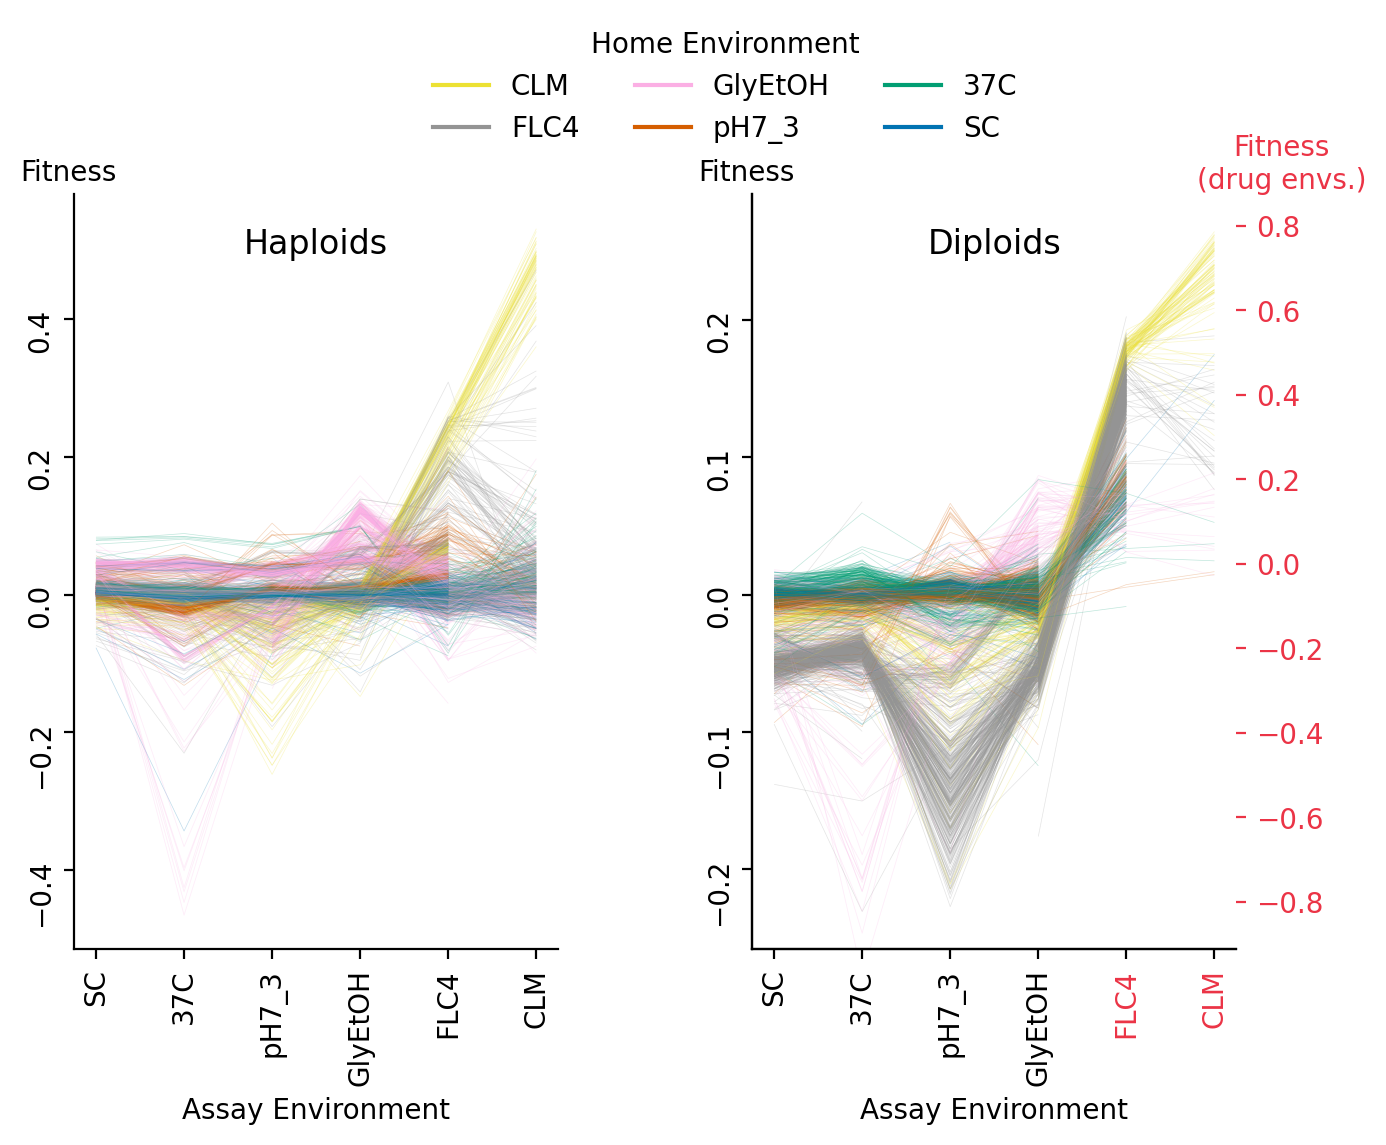

In [18]:
def plot_ut(sub, td, es_all, only_use_envs, title, rescale=[], rescaler=None, clip=None):
    plot_envs(sub, td, es_all, only_use_envs=only_use_envs, title=title, rescale=rescale, clip=clip)
    sub.set_ylabel('Fitness', rotation='horizontal', y=1.01, horizontalalignment='center', labelpad=-15)
    sub.set_xlabel('Assay Environment')
    sub.tick_params(which='both', rotation=90)
    if rescale:
        ax2 = sub.twinx()
        ax2.set_ylim(sub.get_ylim()[0]*rescaler, sub.get_ylim()[1]*rescaler)
        ax2.tick_params(which='both', colors='#eb3446')
        ticks = sub.get_xticklabels()
        jnk = [ticks[i].set_color('k' if es_all[i] not in rescale else '#eb3446') for i in range(len(es_all))]
        ax2.spines['right'].set_color('#eb3446')
        ax2.yaxis.set_label_position("right")
        ax2.set_ylabel('Fitness\n(drug envs.)', rotation='horizontal', y=1.08, horizontalalignment='center', labelpad=-15)
        ax2.yaxis.label.set_color('#eb3446')


f, subs = plt.subplots(1, 2, figsize=(7.5, 5), dpi=200)
plt.subplots_adjust(wspace=0.4)
es = ['SC', '37C', 'pH7_3', 'GlyEtOH', 'FLC4']
es_all = es+['CLM']

# combining haploid data from the two BFAs
b1 = bfa_dats['hBFA1_alpha'][['Barcode', 'Home_Environment', 'Putative_Neutral']+es]
b1['CLM']=np.nan
b2 = bfa_dats['hBFA2_alpha'][['Barcode', 'Home_Environment', 'Putative_Neutral']+es_all]
td = pd.concat([b1, b2])
plot_ut(subs[0], td, es_all, only_use_envs=[i+'_alpha' for i in es_all][::-1], title='Haploids')

# Plotting diploids - just using dBFA2 data here
rescaler=3
plot_ut(subs[1], bfa_dats['dBFA2_2N'], es_all, only_use_envs=[i+'_2N' for i in es_all][::-1], title='Diploids', 
        rescale={'FLC4': 1/rescaler, 'CLM': 1/rescaler}, rescaler=rescaler)

# Trying to line up the zeros
yr = subs[0].get_ylim()
neg_over_pos = np.abs(yr[0])/yr[1]
yr2 = subs[1].get_ylim()
subs[1].set_ylim([yr2[1]*-1*neg_over_pos, yr2[1]])

subs[0].legend(bbox_to_anchor=(2,1.25), ncol=3, frameon=False, title='Home Environment')
sns.despine()

## Loading mutation data

In [34]:
mut_based = dict()
for bfa in bfa_dats:
    mut_based[bfa] = pd.read_csv('Final_data_sets/'+bfa+'_with_mutation_data.csv')
    mut_based[bfa]['Home_Env_Short'] = mut_based[bfa]['Home_Environment'].apply(lambda he: '_'.join(he.split('_')[:-1])) # For coloring

In [35]:
import altair as alt
from altair.expr import datum
# define the theme by returning the dictionary of configurations
def my_style():
    return {
        'config': {
            'view': {
                'stroke': 'transparent', # despine!!!!
                'continuousWidth': 400, 
                'continuousHeight': 300
            },
            'axis': {
                'grid':False, 
                'labelFontSize':16, 
                'titleFontSize':16
            },
            'title': {
                'fontSize': 18
            },
            'mark': {
                'color': 'black'
            }
        }
    }

# register the custom theme under a chosen name
alt.themes.register('my_style', my_style)
alt.themes.enable('my_style')
alt.data_transformers.disable_max_rows();

In [45]:
env_cols = alt.Color('Home_Env_Short', scale=alt.Scale(domain=envs_use, range=[to_hex(colors[e]) for e in envs_use]), legend=None)

def scatter(df, c1, c2):
    td = df[(df[c1].notnull()) & (df[c2].notnull())]

    xr = (np.min(td[c1]), np.max(td[c1]))
    yr = (np.min(td[c2]), np.max(td[c2]))
    if xr[1]-xr[0] > yr[1]-yr[0]:
        use_range = yr
    else:
        use_range = xr
        
    x_line = alt.Chart(pd.DataFrame({'x': xr, 'y': [0,0]})).mark_line(opacity=0.2).encode(x='x', y='y')
    y_line = alt.Chart(pd.DataFrame({'x': [0,0], 'y': yr})).mark_line(opacity=0.2).encode(x='x', y='y')
    
    scatter = alt.Chart().mark_circle().encode(
        x=c1, y=c2,
        #color=alt.condition(datum.Has_Mutation_Data, env_cols, alt.value('#AAAAAA')),
        color=env_cols,
        stroke=alt.value('black'),
        strokeOpacity=alt.condition((bc_hover | bc_click), alt.value(1), alt.value(0)),
        strokeWidth=alt.condition(bc_click, alt.value(8), alt.value(4)),
        tooltip=['Putative_Drivers', 'Lineage_ID', 'Home_Environment']
    ).add_selection(bc_hover, bc_click)
    
    return alt.layer(x_line, y_line, scatter).properties(width=200, height=200)

def big_scatter(bfa_name, home_envs, away_envs):
    td = mut_based[bfa_name][(mut_based[bfa_name]['Home_Env_Short'].isin(home_envs)) & (mut_based[bfa_name]['Has_Mutation_Data'])]
    # Env selector
    env_types = pd.DataFrame({'Home_Env_Short': home_envs})
    env_select = alt.selection_multi(fields=['Home_Env_Short'], init=[{'Home_Env_Short': e} for e in home_envs])
    env_selector = (alt.Chart(env_types).mark_rect()
                       .encode(y=alt.Y('Home_Env_Short', axis=alt.Axis(title=None)), color=env_cols, opacity=alt.condition(env_select, alt.value(1), alt.value(0.2)))
                       .properties(title={'text': 'Home Env.', 'dx': -20})
                       .add_selection(env_select))
    
    s_graphs = alt.vconcat()
    for he in home_envs:
        s_graph_row = alt.hconcat()
        for ae in away_envs:
            s_graph_row = alt.hconcat(s_graph_row, scatter(td, he, ae))
        s_graphs = alt.vconcat(s_graphs, s_graph_row, data=td)

    return alt.hconcat(s_graphs.transform_filter(env_select), env_selector)

bc_hover = alt.selection_single(on='mouseover', fields=['Lineage_ID'], empty='none')
bc_click = alt.selection_single(on='click', fields=['Lineage_ID'], empty='none')

In [48]:
big_scatter('hBFA1_alpha', ['GlyEtOH', 'FLC4'], ['pH7_3', '37C', 'FLC4', 'GlyEtOH']).properties(title='Haploid BFA1')

alt.HConcatChart(...)

In [58]:
big_scatter('hBFA2_alpha', ['FLC4', 'CLM', 'GlyEtOH'], ['pH7_3', '37C', 'FLC4', 'CLM', 'GlyEtOH']).properties(title='Haploid BFA2 (mostly just CLM clones)')

alt.HConcatChart(...)

In [55]:
big_scatter('hBFA2_2N', ['GlyEtOH', 'FLC4'], ['pH7_3', '37C', 'FLC4', 'CLM', 'GlyEtOH']).properties(title='hBFA2 2N')

alt.HConcatChart(...)

In [57]:
big_scatter('dBFA2_2N', ['pH7_3', '37C', 'FLC4', 'CLM', 'GlyEtOH'], ['pH7_3', '37C', 'FLC4', 'CLM', 'GlyEtOH']).properties(title='dBFA2 2N')

alt.HConcatChart(...)